# Model construct Notebook (Colab)

**Contexte, principe et architecture proposé :**

* Emergent World Representations: Exploring a Sequence Model Trained on a Synthetic Task (https://arxiv.org/abs/2210.13382) --> finalement, image-captionning !
* Vision Mamba: Efficient Visual Representation Learning with Bidirectional State Space Model (https://arxiv.org/abs/2401.09417)
* Image Transformer (https://arxiv.org/abs/1802.05751) --> generation image pixel par pixel (voir PixelCNN également)
* Bi-Mamba+: Bidirectional Mamba for Time Series Forecasting (https://arxiv.org/abs/2404.15772)
* MambaByte : MambaByte: Token-free Selective State Space Model (https://arxiv.org/abs/2401.13660)

L'idée est que le modele genere du texte et des pixels sous formes de sequences, lors de la génération d'image, il y aura toujours des sauts de lignes (ASCII OA) lors du démarrage de l'image, mais egalement qu'on atteint la limite de l'image. Si les sequences généré à la suite n'ont pas la meme tailles, ca génére 2 images differentes. La complexité ici est que mamba doit assimiler la tache de "copie" et que l'interpreteur construise logiquement aussi bien les images que le texte. (un peu comme l'art ASCII, mais en ++) --> utiliser des couches d'attention ? à voir si la bidirectionnalité permet d'améliorer la copie.

**Bi-Mamba+ pour la premiere et derniere couches :**

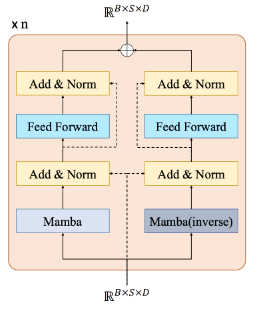

**Code inspiration :**

* https://github.com/hustvl/Vim
* https://github.com/state-spaces/mamba/blob/main/mamba_ssm/models/mixer_seq_simple.py
* https://huggingface.co/JunxiongWang/MambaByte_Arxiv


In [ ]:
!pip install -q mamba-ssm causal-conv1d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.4 MB/s eta 0:00:00

  Preparing metadata (setup.py) ... done

  Preparing metadata (setup.py) ... done

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 9.9 MB/s eta 0:00:00




In [122]:
import torch, math
import skimage as sk
import numpy as np, pylab as plt
from torch import nn
from numpy.lib.stride_tricks import as_strided
from dataclasses import dataclass
from skimage import io, transform, img_as_ubyte
from mamba_ssm.modules.mamba_simple import Mamba

ModuleNotFoundError: No module named 'mamba_ssm'

In [ ]:
d_model, d_state, n_layers = 64, 16, 8
config = MambaConfig(dim=d_model, d_state=d_state, depth=n_layers)

In [ ]:
batch, length = 2, 64
x = torch.randn(batch, length, d_model).to("cuda")
x.shape

torch.Size([2, 64, 64])

In [148]:
def Color_rquantization(img, max_size=20, nb_colors=216):
    # Scale factor calculation
    m, n, _ = img.shape
    scale_factor = max_size / max(m,n) # image.shape[1] # to update to calculate max beetween L or l
    # Resize image
    new_height = int(min(m,n) * scale_factor) #     new_height = int(image.shape[0] * scale_factor)
    if n>m : resized_image  = transform.resize(img, (new_height, max_size), anti_aliasing=True)
    else : resized_image  = transform.resize(img, (max_size, new_height), anti_aliasing=True)
    ## Construct palette
    img = img_as_ubyte(resized_image)
    # cubic root numerotation 
    c = np.rint(np.cbrt(nb_colors)).astype(int)
    # reduce to x level per channel
    img_x = np.rint(img/(255/(c-1))).astype(np.uint8)
    # Convertir image 0 to nb_colors
    img_c = img_x[:, :, 0] * c**2 + img_x[:, :, 1] * c + img_x[:, :, 2]
    # Convertir en image 8 bits
    return img_c.astype(np.uint8)

def input_seq_construct(arr, dim=3):
    if dim % 2 == 0 : dim +=1
    pw = (dim-1)//2
    # Padding around array and size
    padded_arr = np.pad(arr, pad_width=pw, mode='constant', constant_values=0)
    shape = (arr.shape[0], arr.shape[1], dim, dim)
    strides = padded_arr.strides * 2  # double step
    # Data matrix construct
    matrix_dxd = as_strided(padded_arr, shape=shape, strides=strides)
    # include time asymetry (need correction for dim!=3)
    result = np.copy(matrix_dxd).astype(np.uint8)
    result[:, :, pw:, -pw:] = 0
    result[:, :, -pw, :] = 0
    # if image data, including skip line
    if shape[0] > 1 :
        separator = np.zeros((shape[0], 1, dim, dim), dtype=np.uint8)
        separator[:, 0, 1, 1] = 255
        result = np.concatenate((result, separator), axis=1)
        # Linearize
        return result.reshape(-1, dim, dim)[:-1]
    else :
        return result.reshape(-1, dim, dim)

@dataclass
class MambaConfig:
    dim: int # The input dimension of the input tensor.
    d_state: int = 16 #16 # The dimension of the state space model.
    d_conv : int = 4 # The convolutionnal windows
    expand: int = 2 # E in paper/comments
    depth : int = 8 # The number of residual S6 layers

class BysMamba(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()
        self.config = config
        # text & image(t) embedding
        self.vocab_size = 256+216 # ASCII bytes + RGB 6*6*6 pixel
        self.linear_embedding = nn.Embedding(self.vocab_size, config.dim)
        self.patch_embedding = nn.Conv2d(in_channels=1, out_channels=self.vocab_size, kernel_size=3, stride=1, padding=0) # 3D in future
        # mamba part
        self.in_mamba = Mamba(d_model=config.dim, d_state=config.d_state, d_conv=config.d_conv, expand=config.expand,)
        self.layers = nn.ModuleList([Mamba(d_model=config.dim, d_state=config.d_state, d_conv=config.d_conv, expand=config.expand,) for _ in range(config.depth)])
        self.out_mamba = Mamba(d_model=config.dim, d_state=config.d_state, d_conv=config.d_conv, expand=config.expand,)
        # output
        self.lm_head = nn.Linear(config.dim, self.vocab_size, bias=False)

    def forward(self, x):
        # shape : x : (B, L, M=3, N=3)
        B,L,M,N = x.shape
        # embedding
        #xl = x[:, :, M//2, N//2] # img center
        #xl = self.linear_embedding(xl) # (B,L,D)
        xp = self.patch_embedding(input_tensor.view(B*N, 1, 3, 3)).view(B, L, self.vocab_size)
        x = xp #+ xl
        # bidirectional mamba input
        x += self.in_mamba(x) + self.in_mamba(torch.flip(x, dims=[1])).flip([1])
        # mamba intermediate layers
        for layer in self.layers:
            x += layer(x)
        # bidirectional mamba output
        x += self.out_mamba(x) + self.out_mamba(torch.flip(x, dims=[1])).flip([1])
        # prediction output
        x = self.lm_head(x) # probability
        return x

In [ ]:
# test
# bytes([i for i in range(16**3)].decode('utf-8') # doesn't work, max 256
s = [chr(i) for i in range(16**3)]
text_byte = np.frombuffer("".join(s).encode('utf-8'), dtype=np.uint8)
# validation
embedding = nn.Embedding(256+512, d_model).to("cuda") # 256 for ASCII text and 512 for image

In [ ]:
#text = "\documentclass[12pt]{article}"
#text_byte = np.frombuffer(text.encode('utf-8'), dtype=np.uint8)
input_ids = torch.from_numpy(text_byte[None, :]).long().cuda()
input_ids.shape

torch.Size([1, 10112])

In [ ]:

x_ = embedding(input_ids)
x_.shape

torch.Size([1, 10112, 64])

In [ ]:
model = BysMamba(config).to("cuda")
y = model(x_)
y.shape

torch.Size([1, 10112, 768])

In [144]:
image = sk.data.astronaut()
quant_img = Color_rquantization(image)
img_seq = input_seq_construct(quant_img, dim=3) # None for batch
img_seq = np.stack((img_seq, img_seq))
img_seq.shape

(2, 419, 3, 3)

In [145]:
B, N, _,_ = img_seq.shape
# 1. Convertir en tensor PyTorch
input_tensor = torch.from_numpy(img_seq).float()  # Shape: (2, N, 3, 3)

# 2. Réorganiser le tensor pour avoir la forme (N, 1, 3, 3)
input_tensor = input_tensor.view(B*N, 1, 3, 3)  # (N, 1, 3, 3)

# 3. Définir la couche de convolution
P = 216  # Nombre de filtres de sortie
conv_layer = nn.Conv2d(in_channels=1, out_channels=P, kernel_size=3, stride=1, padding=0)

# 4. Appliquer la convolution sur le lot entier
output = conv_layer(input_tensor)  # Shape: (N, P, H_out, W_out)

# 5. Redimensionner pour obtenir la forme (1, N, P)
output_reshaped = output.view(B, N, P)  # Shape: (1, N, P)

print(output_reshaped.shape)  # Devrait afficher torch.Size([1, 419, 216])

torch.Size([2, 419, 216])


In [50]:
# for inference show (need to create)
def colors_216_to_rgb(img):
    # Convertir les valeurs de 0-215 en RGB
    r = (img // 36) * 51
    g = ((img % 36) // 6) * 51
    b = (img % 6) * 51
    # Combiner les canaux RGB
    return np.stack([r, g, b], axis=-1).astype(np.uint8)